In [5]:
!pip install squarify
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 127.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 146.1 MB/s eta 0:00:00


In [39]:
import os
import sys
import math
import ast
import datetime
import glob
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pingouin
import squarify
from tqdm.notebook import tqdm

In [7]:
object_data = pd.read_csv('./2024_Mar_ob_count.csv')

In [12]:
# Create array of category names as they appear in the detections data. See paper for details of each category.
categories = ['car', 'person', 'trotro', 'stall', 'truck', 'stove', 'motorcycle', 'vendor', 'lorry', 'umbrella', 'bus', 'trash', 'taxi', 'van', 'debris', 'loudspeaker', 'bowl', 'food', 'animal', 'bicycle']

# Column names in the data frame for the number of counts of each category type in an image.
count_cols = [cat+'_counts' for cat in categories]

vehicle_categories = ['car', 'trotro', 'truck', 'motorcycle', 'lorry', 'bus', 'taxi', 'van', 'bicycle']

super_categories = {'people' : ['person','vendor'],
                    'small_vehicles' : ['car', 'taxi','truck'],
                    'two_wheelers' : ['bicycle', 'motorcycle'],
                    'large_vehicles' : ['trotro', 'van', 'lorry','bus'],
                    'refuse' : ['trash', 'debris'],
                    'market': ['umbrella','stall','bowl','food']}

In [10]:
object_data['datetime'] = pd.to_datetime(object_data['datetime'], format='%Y-%m-%d %H:%M:%S')

In [42]:
# Filter rows where the lowercase first letter of 'site_id' is not 's'
fixed_object_data = object_data[~object_data['site_id'].str.lower().str.startswith('s')]

# Display the first few rows of the new dataframe to verify
fixed_object_data.head()


,directory,image_name,datetime,date,site_id,camera_name,animal_counts,bicycle_counts,bowl_counts,bus_counts,...,person_counts,stall_counts,stove_counts,taxi_counts,trash_counts,trotro_counts,truck_counts,umbrella_counts,van_counts,vendor_counts
0,AD_12_04_2019_C14,MFDC0294.JPG,2019-04-12 10:25:49,2019-04-12,AD,C14,0,0,0,0,...,32,0,0,6,0,3,0,0,1,0
1,AD_12_04_2019_C14,MFDC0295.JPG,2019-04-12 10:30:49,2019-04-12,AD,C14,0,1,0,0,...,29,1,0,3,0,1,1,0,1,0
2,AD_12_04_2019_C14,MFDC0296.JPG,2019-04-12 10:35:49,2019-04-12,AD,C14,0,0,0,0,...,28,1,0,2,0,2,2,0,1,0
3,AD_12_04_2019_C14,MFDC0297.JPG,2019-04-12 10:40:49,2019-04-12,AD,C14,0,0,0,0,...,21,1,0,2,0,1,1,1,1,0
4,AD_12_04_2019_C14,MFDC0298.JPG,2019-04-12 10:45:49,2019-04-12,AD,C14,0,0,0,0,...,30,1,0,1,0,2,4,0,1,0


In [44]:
# Group by 'site_id' and aggregate unique 'camera_name' into lists
site_cams = fixed_object_data.groupby('site_id')['camera_name'].unique().apply(list).to_dict()

site_type = {'AD': ['Asylum Down', 'Commercial/\nbusiness/\nindustrial','blue'],
             'ASH' : ['Ashaiman', 'Medium/low-density\nresidential', 'tab:orange'],
             'EL': ['East Legon', 'Medium/low-density\nresidential', 'tab:orange'],
             'JT' : ['James Town', 'High-density\nresidential', 'red'],
             'LA': ['Labadi', 'Medium/low-density\nresidential', 'tab:orange'],
             'N1W': ['N1 West Motorway', 'Commercial/\nbusiness/\nindustrial','blue'],
             'NM': ['Nima', 'High-density\nresidential', 'red'],
             'TF': ['Taifa','Medium/low-density\nresidential', 'tab:orange'],
             'TMW': ['Tema Motorway', 'Commercial/\nbusiness/\nindustrial','blue'],
             'UGH': ['University of Ghana', 'Peri-urban background', 'green']}

print(site_cams)

{'AD': ['C14', 'C17', 'C4', 'C12', 'S21', 'C5', 'C22'], 'ASH': ['C6', 'C13', 'C22', 'C11'], 'EL': ['C28', 'C18', 'C32', 'C01', 'C8', 'C12', 'C10', 'C41', 'S85', '2021', 'C15', 'C36', 'C11', 'C20', 'S75'], 'JT': ['C31', 'C11', 'C21', 'C9', 'C28', 'C44', 'S44', 'C14'], 'LA': ['C35', 'C16', 'C25', '2022', 'C01', 'C28', 'C8', 'C14', 'C18'], 'N1W': ['C36', 'C15', 'C34', 'C8', 'C33', '36', 'S15', 'C41', 'C12', 'C18', 'C19'], 'NM': ['C26', 'C02', 'C2', 'C13', 'S17', 'C27', 'C33', 'C32', 'C40', '2021', 'C44', 'C21'], 'TF': ['C21', 'C22', 'C32', 'C11', 'C5', 'C28', 'C26', 'C42', 'C23', '26', 'C14', 'S75'], 'TMW': ['2019', 'C30', 'C19', 'C1', 'C14', 'C20', 'C12', 'C11'], 'UGH': ['C25', 'C5', 'C12', 'C33', 'C23', 'C42', 'C', 'C30', 'C36']}


In [45]:
obj_categories = ['person','umbrella', 'stall', 'food', 'bowl', 'car', 'taxi', 'truck','bicycle', 'motorcycle', 'animal','trotro', 'van', 'lorry', 'debris', 'trash', 'vendor', 'loudspeaker', 'stove', 'bus']

print(fixed_object_data[[cat+'_counts' for cat in obj_categories]].sum())

person_counts         34350600
umbrella_counts       12336975
stall_counts             82419
food_counts             302845
bowl_counts            1445213
car_counts            14726597
taxi_counts            2680311
truck_counts           1362327
bicycle_counts          266033
motorcycle_counts       999406
animal_counts            37420
trotro_counts         10110304
van_counts              787301
lorry_counts            345895
debris_counts           549955
trash_counts           1943041
vendor_counts           715103
loudspeaker_counts       58902
stove_counts             16929
bus_counts              157736
dtype: int64


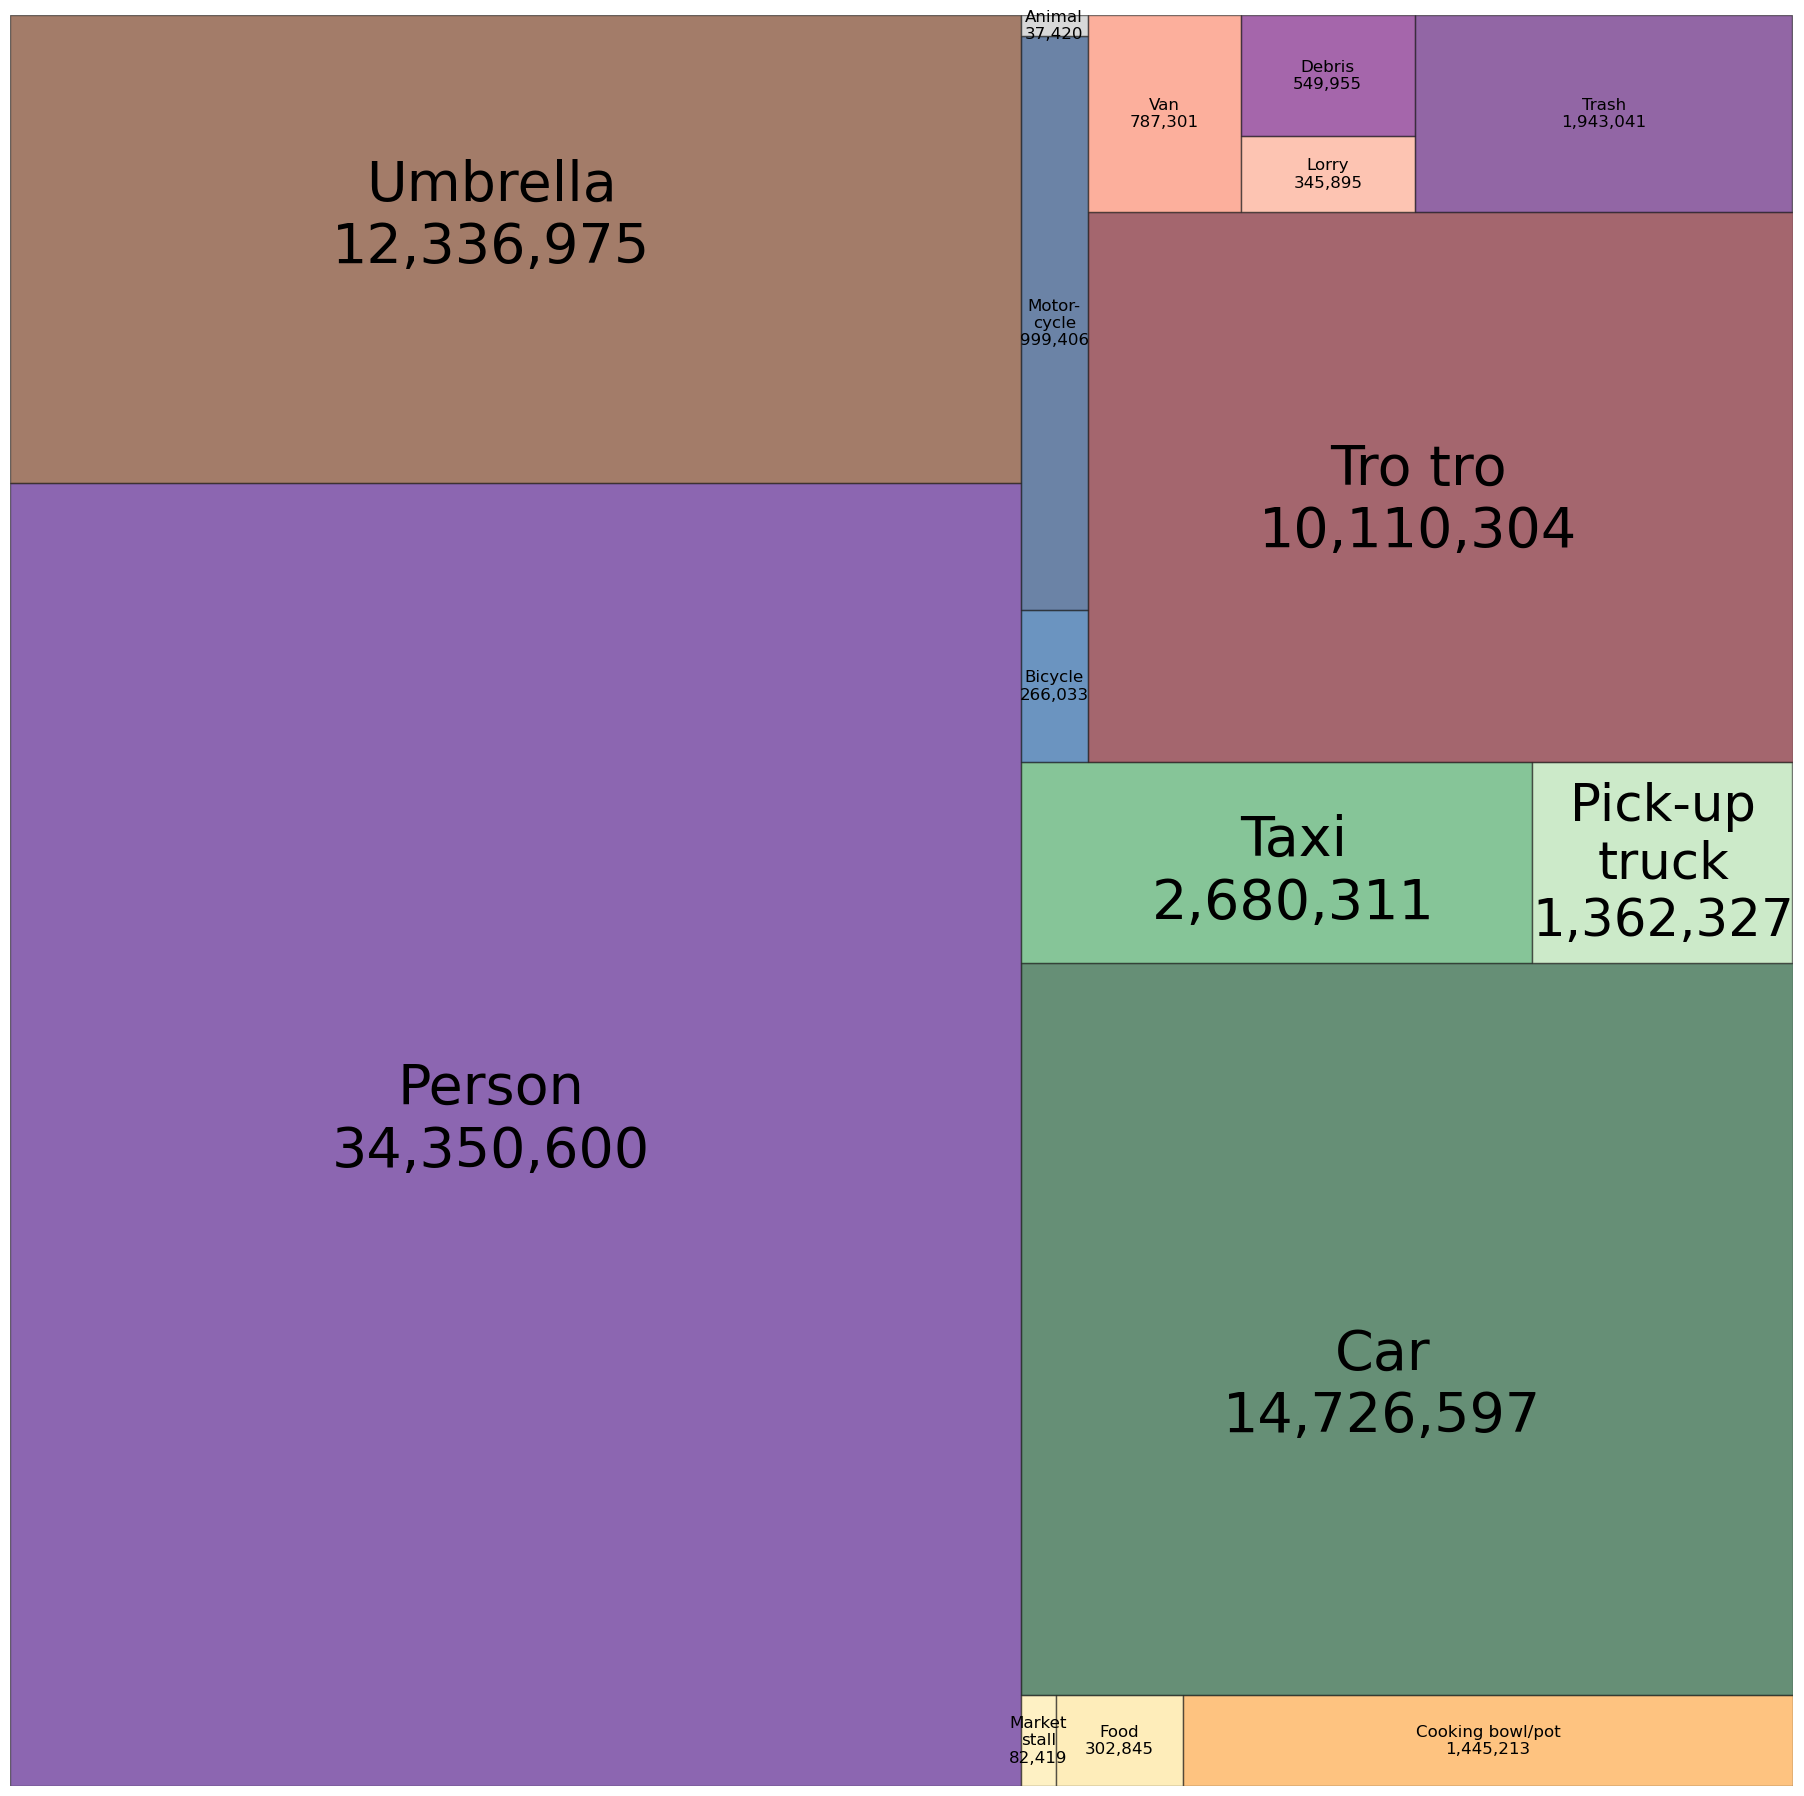

In [46]:
# Treemap generation

import matplotlib.colors as colors
fig, ax = plt.subplots(figsize=(23,23),linewidth=0)

tree_categories = ['person','umbrella', 'stall', 'food', 'bowl', 'car', 'taxi', 'truck','bicycle', 'motorcycle', 'animal','trotro', 'van', 'lorry', 'debris', 'trash']

total_counts = fixed_object_data[[cat+'_counts' for cat in tree_categories]].sum()#.sort_values(ascending=False)

sizes=[float(size/10000) for size in total_counts.values]

label=[obj[0].replace("trotro","tro tro")
             .replace("truck","pick-up\ntruck")
             .replace("stall","market\nstall")
             .replace("bowl","cooking bowl/pot")
             .replace("_counts","\n"+str(f"{int(obj[1]):,}")).capitalize().replace("rcycle","r-\ncycle") for obj in zip(total_counts.index,total_counts.values)]
label_mod=label.copy()

for i in [0,1,5,6,7,11]:
    label_mod[i]= ""

cmap_1 = plt.cm.Purples
cmap_2 = plt.cm.YlOrBr
cmap_3 = plt.cm.Greens
cmap_4 = plt.cm.Blues
cmap_5 = plt.cm.Greys
cmap_6 = plt.cm.Reds
cmap_7 = plt.cm.RdPu

norm_1 = colors.Normalize(vmin=0, vmax=4000000)
norm_2 = colors.Normalize(vmin=-1000000, vmax=4000000)
norm_3 = colors.Normalize(vmin=0, vmax=4000000)
norm_4 = colors.Normalize(vmin=0, vmax=300000)
norm_5 = colors.Normalize(vmin=0, vmax=100000)
norm_6 = colors.Normalize(vmin=-1000000, vmax=3000000)
norm_7 = colors.Normalize(vmin=0, vmax=600000)

colors = [cmap_1(norm_1(value)) for value in total_counts.values[:1]]+\
         [cmap_2(norm_2(value)) for value in total_counts.values[1:5]]+\
         [cmap_3(norm_3(value)) for value in total_counts.values[5:8]]+\
         [cmap_4(norm_4(value)) for value in total_counts.values[8:10]]+\
         [cmap_5(norm_5(value)) for value in total_counts.values[10:11]]+\
         [cmap_6(norm_6(value)) for value in total_counts.values[11:14]]+\
         [cmap_7(norm_7(value)) for value in total_counts.values[14:]]

#print(label)
squarify.plot(sizes=sizes, label=label_mod, color=colors, alpha=0.6,text_kwargs={'fontsize':12, 'color':'black', 'fontweight':"medium"},bar_kwargs=dict(linewidth=1, edgecolor="#222222"))
fontsize = 40
plt.text(27,35, label[0], color='black',fontsize=fontsize,alpha=1,horizontalalignment='center')
plt.text(27, 86, label[1], color='black',fontsize=fontsize,alpha=1,horizontalalignment='center')
plt.text(77, 20, label[5], color='black',fontsize=fontsize,alpha=1,horizontalalignment='center')
plt.text(72, 49, label[6], color='black',fontsize=fontsize,alpha=1,horizontalalignment='center')
plt.text(92.75, 48, label[7], color='black',fontsize=fontsize-3,alpha=1,horizontalalignment='center')
plt.text(79, 70, label[11], color='black',fontsize=fontsize,alpha=1,horizontalalignment='center')
plt.axis('off')
plt.show()
fig.savefig('./results/treemap.pdf',format='pdf',edgecolor="#000000", bbox_inches='tight', pad_inches=0.1)

In [ ]:
# Count unique cameras per site per day
camera_counts_per_day = fixed_object_data.groupby(['site_id', fixed_object_data['datetime'].dt.date])['camera_name'].nunique().reset_index(name='camera_counts')

# Pivot table to have dates as index and sites as columns, filling missing values with 0
pivot_camera_counts = camera_counts_per_day.pivot(index='datetime', columns='site_id', values='camera_counts').fillna(0)

# Replace site_id with full names from site_type
pivot_camera_counts.columns = pivot_camera_counts.columns.map(lambda x: site_type[x][0] if x in site_type else x)

colors = {0: 'grey', 1: 'blue', 2: 'green', 3: 'yellow', 4: 'red'}

import matplotlib.dates as mdates
from matplotlib.dates import date2num

fig, ax = plt.subplots(figsize=(15, 8))
plt.yticks(range(len(pivot_camera_counts.columns)), pivot_camera_counts.columns)

for i, site in tqdm(enumerate(pivot_camera_counts.columns), total=len(pivot_camera_counts.columns), desc="Plotting Progress"):
    for date, count in pivot_camera_counts[site].items():
        # Convert 'date' to a numerical format that matplotlib understands
        date_num = date2num(date)
        # Ensure colors is a dictionary and use the 'get' method to handle missing keys gracefully
        ax.scatter(date_num, i, color=colors.get(count, 'black'), s=50)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Sites')
plt.title('Camera Operation Time Series by Site')

# Create legend elements based on 'colors' dictionary
legend_elements = [Line2D([0], [0], marker='o', color='w', label='{} cameras'.format(i), markerfacecolor=color, markersize=10) for i, color in colors.items()]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

Plotting Progress:   0%|          | 0/10 [00:00<?, ?it/s]